In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

import os

from PIL import Image

Using TensorFlow backend.


In [2]:
def load_data():
        data = []
        small = []
        paths = []
        #get all files in this folder
        for r, d, f in os.walk(r"D:\Downloads\selfie2anime\trainB"):
            for file in f:
                if '.jpg' in file:
                    paths.append(os.path.join(r, file))
        #for each file add normal resolution and low resolution to arrays
        for path in paths:
            img = Image.open(path)
            x = np.array(img.resize((128,128)))
            y = np.array(img)
            #x = x[...,:3]
            data.append(y)
            small.append(x)
            
        #reshaping data to be four dimension required for input to neural network
        y_train = np.array(data)
        y_train = y_train.reshape(len(data),256,256,3)
        x_train = np.array(small)
        x_train = x_train.reshape(len(small),128,128,3)
        return y_train, x_train

In [3]:
class SRGAN():
    def __init__(self):
        
        # Shape of high resolution output image
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        # Shape of low resolution input image
        self.latent_dim = (128,128,3)

        #optimizer (learning rate and beta values)
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        generator = self.generator

        # The generator takes noise as input and generates imgs
        z = Input(shape=self.latent_dim)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()
        model.add(Conv2D(100, input_shape=(128, 128, 3), kernel_size=(3,3), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(100, kernel_size=(3,3), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(100, kernel_size=(2,2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(100, kernel_size=(4,4), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(100, kernel_size=(3,3), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(3, kernel_size=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.summary()

        noise = Input(shape=self.latent_dim)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        Y_train, X_train = load_data()

        # Rescale to be between 0 & 1
        X_train = X_train / 255
        Y_train = Y_train / 255

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Placeholder for loss function values
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, Y_train.shape[0], batch_size)
            imgs = Y_train[idx]

            # Generate super resolution images from the random batch of images
            gen_imgs = self.generator.predict(X_train[idx])

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(X_train[idx], valid)
            
            #save loss history
            g_loss_epochs[epoch] = g_loss
            d_loss_epochs[epoch] = d_loss[0]

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, X_train, idx)
                
        return g_loss_epochs, d_loss_epochs

    def save_imgs(self, epoch, X_train, idx):
        r, c = 3, 3
        # Select 9 random images
        index = np.random.randint(0, X_train.shape[0], 100)
        images = X_train[idx]
        # Super resolution the images
        gen_imgs = self.generator.predict(images)
        gen_imgs = np.array(gen_imgs) * 255
        gen_imgs = gen_imgs.astype(int)
        # Plot each image
        fig=plt.figure(figsize=(20, 20))
        for i in range(1, c*r+1):
            img = gen_imgs[i-1]
            fig.add_subplot(r, c, i)
            plt.imshow(img)
        fig.savefig(r"C:\Users\Vee\Desktop\python\GAN\epoch_%d.png" % epoch)
        plt.close()
        # save model to .h5 file
        self.generator.save("generator.h5")

In [4]:
gan = SRGAN()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 64)       

In [5]:
g_loss, d_loss = gan.train(epochs=15001, batch_size=10, save_interval=100)

C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 [D loss: 6.969592, acc.: 0.00%] [G loss: 0.005102]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Di

1 [D loss: 2.384718, acc.: 50.00%] [G loss: 6.356820]
2 [D loss: 2.854330, acc.: 50.00%] [G loss: 0.512411]
3 [D loss: 1.616534, acc.: 40.00%] [G loss: 2.824306]
4 [D loss: 1.054743, acc.: 50.00%] [G loss: 0.116595]
5 [D loss: 0.274192, acc.: 90.00%] [G loss: 0.076065]
6 [D loss: 0.079594, acc.: 100.00%] [G loss: 0.008731]
7 [D loss: 0.064523, acc.: 100.00%] [G loss: 0.009148]
8 [D loss: 0.016420, acc.: 100.00%] [G loss: 0.032681]
9 [D loss: 0.054267, acc.: 100.00%] [G loss: 0.034988]
10 [D loss: 0.046260, acc.: 100.00%] [G loss: 0.053243]
11 [D loss: 0.035701, acc.: 100.00%] [G loss: 0.125030]
12 [D loss: 0.109237, acc.: 100.00%] [G loss: 0.157317]
13 [D loss: 0.589450, acc.: 70.00%] [G loss: 11.023188]
14 [D loss: 5.856387, acc.: 0.00%] [G loss: 7.023002]


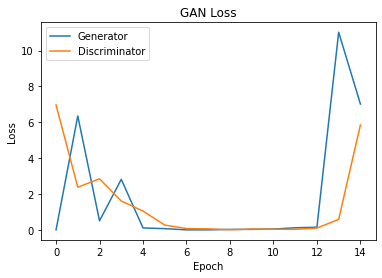

In [6]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Generator', 'Discriminator'], loc='upper left')
plt.show()